In [ ]:
"""
Approach:
- create a bag-of-words for each of: fact1, fact2, question, answer.
- remove stopwords, as well as sentence punctuation and all verbs.
- create 2-grams using the bag-of-words

Evaluation:
- using this method, given that one of the facts states where john is, 
  we can say where he is correctly with high certainty and probability.

Limitations:
- approach only works for previously seen people and places
- if the given facts do not contain the answer to the question, 
  we don't know with certainty where the person is, as we don't keep previous facts in memory.
  
  (note the model does remember places john has been to in the past 
  based on previous examples in the training data and thus scores 
  some places more likely than others)
  
Next Steps:
- could add a 7th "don't know/can't remember" answer given low certainty, would have to relabel 
  train/test data.
  
- discover a way that the classifier can remember where the person was last
- discover a way to generalise the model to unseen people and places

"""

In [1]:
import os
import sys
%reload_ext autoreload
%autoreload
%matplotlib inline

project_root = os.path.abspath(os.path.join('../../../'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pandas as pd
from ml_workbench.src.data_loaders.BablTask1Loader import split_parse_data

X_train, y_train = split_parse_data('/Users/enrico.t/code/ml_workbench/' + 
  'data/tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt')

X_test, y_test = split_parse_data('/Users/enrico.t/code/ml_workbench/' + 
 'data/tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from ml_workbench.src.vectorizers.ColumnBowVectorizer import ColumnBowVectorizer

pipeline = Pipeline([
    ('bow', ColumnBowVectorizer()),
    ('clf', SVC(probability=True))
])

parameters = {
    'clf__C': [1, 5,  10, 100, 1000],
    'clf__gamma': [10, 5, 1, 0.1, 0.001, 0.0001],
}

grid = GridSearchCV(
    pipeline, 
    parameters, 
    cv=3,
    n_jobs=-1, 
    verbose=1
)

grid.fit(X_train, y_train)
y_predict = grid.predict(X_test)
print grid.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'clf__gamma': 1, 'clf__C': 1}


In [4]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(y_test.values.flatten(), y_predict)
cm.print_stats()

/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted  bathroom  bedroom  garden  hallway  kitchen  office  __all__
Actual                                                                 
bathroom        117        8      12        1        3       8      149
bedroom           5      126      20        3       10       7      171
garden            4       11     155        4        4       9      187
hallway           5        7      20      110        3       9      154
kitchen           5        4      21        4      118       5      157
office            4        9      27       10        6     126      182
__all__         140      165     255      132      144     164     1000


Overall Statistics:

Accuracy: 0.752
95% CI: (0.7240157794869074, 0.7784918701625345)
No Information Rate: ToDo
P-Value [Acc > NIR]: 6.17252249132369e-237
Kappa: 0.701368886491277
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                 bathroom    bedroom    garden  \
Population                  

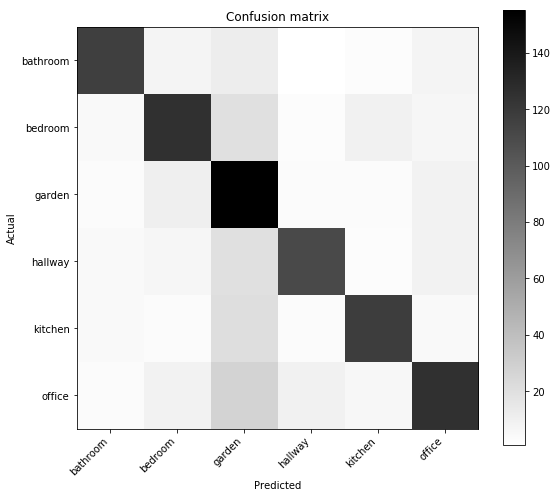

In [5]:
cm.plot()

In [17]:
y_proba_predict = grid.predict_proba(X_test)

print X_test.iloc[0], y_test.iloc[0]
print y_proba_predict[0]

# classifier is 96% sure that john is in the hallway, as one of the given facts attests to it

fact1        John travelled to the hallway.
fact2       Mary journeyed to the bathroom.
question                    Where is John? 
Name: 0, dtype: object answer    hallway
Name: 0, dtype: object
[0.00864296 0.0082998  0.00594928 0.9658889  0.00494352 0.00627553]
[0.10791962 0.11433394 0.28893045 0.24769605 0.10051359 0.14060635]


In [18]:
print X_test.iloc[1], y_test.iloc[1]
print y_proba_predict[1]

# classifier doesn't know from the facts where john is, which is reflected in the probabilities. 

fact1       Daniel went back to the bathroom.
fact2              John moved to the bedroom.
question                      Where is Mary? 
Name: 1, dtype: object answer    bathroom
Name: 1, dtype: object
[0.10791962 0.11433394 0.28893045 0.24769605 0.10051359 0.14060635]


In [ ]:
# actually a previous fact states that mary is in the bathroom, looks like the tasks follow one another.

# looks like there's also a sequence dependency between the facts, in test[3] the correct answer can only
# be known if fact 2 happened after fact 1.